The basics of the Non-doinated Sorting Genetic Algorithm are http://ieeexplore.ieee.org/document/996017/

In [1]:
%matplotlib inline
#Importing required modules
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import scipy.stats as stats
import warnings
from matplotlib.colors import LogNorm
from prettytable import PrettyTable
import optunity

# 0. Function definition


## 0.0 $\textit{Individual}$ class definition for the sorting function 

In [2]:
# This class will be used in the fastNonDominatedSorting to make a neat code
class Individual(object):
    p = []
    n = 0
    # Each individual will have p and n
    def __init__(self, p, n):
        self.p = p
        self.n = n

## 0.1 $\prec$ operator
The dominance operation is usually defined mathematicaly as:
\begin{matrix}
    f_i(x^1) \leq f_i(x^2) && \text{for all } i \text{ in } i \in {1, 2, ..., k}\\
    f_i(x^1) < f_i(x^2) && \text{for at least one } i \text{ in } i \in {1, 2, ..., k}
\end{matrix}

In [3]:
def prec_operator(P,Q):
    """Implementation of the dominance operator to sort a set of points.
    
    INPUTS:
    P:    first point (value in the function domain) with numpy.ndarray type
    Q:    second point (value in the function domain) with numpy.ndarray type
     
    OUTPUT:
    bool: True if P < Q and False if Q < P
    
    
    The dominance (precedant) operator returns True or False depending on the values 
    that the different functions have for each point. This follows the formal definition
    of the precedant operator: in order have a point dominating another, the values of 
    the functions should be smaller or equal for all objectives, having AT LEAST one for 
    which the values is strictly smaller than the dominated points 
    """
        
    # Number of variables
    var = P.shape[0]
    
    # Dimensions between p and q must match
    if var != Q.shape[0]:
        raise ValueError("P and Q dimensions don't match")
    
    # If all elements in P are smaller than those in Q, then P is dominating
    if np.sum(P < Q) == var:
        return True
    # Formal dominance-operator definition
    elif np.sum(np.logical_or(P < Q, P == Q)) == var and np.sum(P < Q) >= 1: 
        return True
    else:
        return False

## 0.2 $\texttt{fastNonDominatedSort}$ function 
Extracted from http://ieeexplore.ieee.org/document/996017/

In [4]:
def fastNonDominatedSort(P):
    """fast-non-dominated-sorting algorithm decribed in the NSGA-II paper
    
    INPUT:
    P:  point evaluations in the function space as a numpy.ndarray
    
    OUTPUT:
    PF: Pareto Front points in a list (number of PF) of numpy.ndarray (points)
    F:  index points in a list (number of PF) of numpy.ndarray (index)
    
    
    The function analyzes the value of the functions in the array P and sort the points 
    in Pareto Fronts, having that PF[0] contains the non dominated values in the set P, 
    PF[1] contains the values of the first dominated set, PF[1] the values of the second, 
    and so on. List F[] has the same idea of PF[] but containing the index of the points 
    instead of the true value of the point.
    """
    
    # Number of variables of the problem
    var = P.shape[1]
    # Possible solutions
    ps = P.shape[0] 
    ind = []
    # Pareto front list
    F = []
    # Let's create an empty array for the 1st Pareto front
    F1 = np.empty((0,1), float) # Just the index of the point will be stored

    for i in range(ps):
        # Dominated solutions for each p and its domination count n_p for the solution 
        S_p = np.empty((0,1), float) 
        n_p = 0
        for j in range(ps):
            # If p dominates q in all variables it will be smaller in all variables
            if prec_operator(P[i],P[j]): 
                S_p = np.append(S_p, j) # Add q to the set of solutions dominated by p
            elif prec_operator(P[j],P[i]):
                n_p += 1 # Increment the domination counter of p
        if n_p == 0: # p belongs to the first front
    #         p_rank = 1 
            F1 = np.append(F1, i) # Let's include the rank after the two main variables
        ind.append(Individual(S_p, n_p))
    # Store the first frontier in the frontiers list
    F.append(F1.astype(int))

    front = 0

    while len(F[front]) != 0:
        Q = np.empty((0,1), float) # Used to store the members of the next front
        for i in range(F[front].size): 
            for j in range(ind[int(F[front][i])].p.size):
                # Reduce the domination counter by 1
                ind[int(ind[int(F[front][i])].p[j])].n -= 1 
                # q belongs to the next front if its n == 0
                if ind[int(ind[int(F[front][i])].p[j])].n == 0: 
#                     q_rank = front + 2 
                    Q = np.append(Q, int(ind[int(F[front][i])].p[j]))
        front += 1
        F.append(Q.astype(int))

    # Let's create the values of the points instead index
    PF = []
    for i in range(front):
        PF.append(P[F[i].astype(int).tolist()])
        
    return PF, F

## 0.3 $\texttt{crowdingDistanceAssignment}$ function 
Extracted from http://ieeexplore.ieee.org/document/996017/

In [5]:
def crowdingDistanceAssignment(PF):
    """Assignment of a crowding distance value for a specific Pareto Front.
    
    INPUT:
    PF: specific Pareto Front values in the function space as numpy.ndarray
    
    OUTPUT:
    I:  crowding distance between points as a numpy.ndarray
    
    
    The implementation is based on the procedure proposed in the NSGA-II paper:
        - Assign a value in the extrema of infinity
        - Computes the crowding distance between the other points
        - Store the results following the same order as the points in PF
    """
    l = PF.shape[0] # Number of solutions in PF
    m = PF.shape[1] # Number of objective functions
    I = np.zeros((l,m)) # Preallocate distance
    for i in range(m):
        temp = PF[np.argsort(PF[:,i])] # Sort by using objective value m
        # Boundary points are selected as infinite so they will always be choosen
        I[np.argsort(PF[:,i])[0],i] = float('inf') 
        I[np.argsort(PF[:,i])[-1],i] = float('inf')
         # For the points that are not in the boundaries
        for j in range(1,l-1):
            I[np.argsort(PF[:,i])[j],i] = (temp[j+1,i] - temp[j-1,i])/(temp.max(axis=0)[i]-temp.min(axis=0)[i])  
        # Value normalization with 1 as maximum value only if it is bigger than 2
        if l > 2:
            I[:,i] = I[:,i]/np.max(I[I[:,i]!=np.inf,i])
            
    return I

## 0.4 $\prec_n$ sorting
Although $\prec_n$ is described in http://ieeexplore.ieee.org/document/996017/ as:
$$
i \prec_n j \text{ if any of these is true }
\begin{Bmatrix}
    i_{rank} < j_{rank} \\
    i_{rank} == j_{rank} \ \ \mathbf{ and } \ \ i_{dist} > j_{dist}
\end{Bmatrix}
$$

In order to make a complete comparison with all the objective functions, the next function:
* Receives two vectors containing the rank and the crowding distance in each one of the objectives
* The points are sorted by comparing the mean of both objective functions in order to untie any possible mismatch between them

In [6]:
def prec_n_operator(rank, crowd):
    """Implementation of the precedent_n operator to sort a set of points.
    
    INPUTS:
    rank:  ranking of the individuals as a numpy.ndarray 
    crowd: crowding distances stored in a numpy.ndarray
    
    OUTPUT:
    fObj:  returns a numpy.ndarray with the index of the sorted points (as integers)
    
    
    The implementation follows a close procedure to the one described in NSGA-II paper but 
    untie possible objective mismatches by using the mean to get the point located in the
    less populated area (bigger densities and bigger max(rank)-rank first)
    """
    
    # Let's invert the ranks to sort descending in all variables. Thus, the highest
    # the value of the new rank, the better Pareto front the point is located in.
    rank = max(rank) - rank

    # Descending sorted matrix taking into account rank and mean of crowding distances
    obj = np.flipud(np.lexsort(((crowd[:,0]+crowd[:,1])/2,rank)))
    # Before returning the index list, check if there is no repeated number
    if any(np.unique(obj, return_counts=True)[1] != 1):
        # If there it is, return a warning
        warnings.warn("Repeated numbers in the prec_n_operator output")
    # Return the solution
    return obj.astype(int)

## 0.5 $\texttt{preSelection}$ function
Extracted from http://ieeexplore.ieee.org/document/996017/

In [7]:
def preSelection(P, Q, funEvalP, funEvalQ):
    """Selection based on the mixing of parents and offsprings 
    
    INPUTS:
    P:        parents [p-1] (in parameter space) as a numpy.ndarray
    Q:        offspring [p] (in parameter space) as a numpy.ndarray
    funEvalP: parents (in function space) as a numpy.ndarray
    funEvalQ: offsprings (in function space) as a numpy.ndarray
    
    OUTPUT:
    newP:     new population ready for selection, crossover...


    This function mix the population of parents (generation [p-1]) and offsprings 
    (generation [p]). Then it is sorted following the non-dominated sorting, taking 
    the whole fronts when they fill completely the new population size. Once the next
    front doesn't fit into the new population vector, it is sorted by crowding distance
    picking the ones that have higher values of crowding distances (and recomputing the
    crowding distance each time an individual is taken out the Pareto front)
    """
    
    N = len(P)
    # Combine parent and offspring population
    R = np.concatenate((P,Q))
    funEvalR = np.concatenate((funEvalP,funEvalQ))
    
    # Let's sort all the nondominated fronts of R
    PF, F = fastNonDominatedSort(funEvalR)
    
    # Store the Pareto Front number of each one of the P points
    PFnumber = np.zeros(len(np.concatenate(PF))) 
    count = 0
    for pfn in range(len(F)):
        for pfe in range(len(F[pfn])):
            PFnumber[F[pfn][pfe].astype(int)] = pfn
            count += 1

    # New generation should have the same number of individuals as the previous one
    newP = np.zeros((N, 7)) # coord1 - coord2 - fun1 - fun2 - rank - crowd1 -crowd2

    i = 0
    nPcount = 0
    
    # Until the parent population is filled
    while np.sum(newP.any(axis=1)) + len(F[i]) <= N:
        # Calculate the crowding-distance for F[i]
        crowdDA = crowdingDistanceAssignment(funEvalR[F[i]])
        # Include the i-th nondominated front in the parent population
        for j in range(len(F[i])):
            newP[nPcount,:] = np.hstack((R[F[i][j],:], funEvalR[F[i][j],:], PFnumber[F[i][j]], crowdDA[j,:]))
            nPcount += 1
        # Check the next front for inclusion
        i += 1   
        
    # Compute the crowding distance for the next F[i] 
    crowdDA = crowdingDistanceAssignment(funEvalR[F[i]])
    # Sort in descensing order using the prec_n operator
    sortedFl = prec_n_operator(PFnumber[F[i]],crowdingDistanceAssignment(funEvalR[F[i]]))
    # sortedFl = prec_n_operator(PFnumber[F[i]],crowdDA)

    # Choose the first (N-len(F[i])) elements of F[i]
    stillEmpty = N - np.sum(newP.any(axis=1))
    
    # Go through the elements that may be chosen
    for j in sortedFl[0:stillEmpty]:
        newP[nPcount,:] = np.hstack((R[F[i][j],:], funEvalR[F[i][j],:], PFnumber[F[i][j]], crowdDA[j,:]))
        nPcount += 1
   
    # Return the new population ready to selection
    return newP

## 0.6 $\texttt{binaryTournament}$ function
The algorithm for the binary tournament selection has been coded following: http://www.tik.ee.ethz.ch/file/6c0e384dceb283cd4301339a895b72b8/TIK-Report11.pdf

In [8]:
def binaryTournament(rank, crowd):
    """Binary tournament selection process based on the precedent_n operator
    
    INPUTS:
    rank:  rank (Pareto front number) in which points are located
    crowd: crowding distance of the points that will be confronted
    
    OUTPUT:
    index: index of the winning individual
    
    
    The basic operation that this function performs is the selection of two
    random individuals from a list, comparison of its rank and crowding 
    distance and select the winner based on the precedent_n operator
    """
    
    # Get the size of the population
    N = rank.shape[0]
    
    # Dimensions between rank and crowd must match
    if N != crowd.shape[0]:
        raise ValueError("Rank and crowd dimensions don't match")
    
    # Create an array with the N possible index positions
    indx = np.linspace(0,N-1,N).astype(int)
    
    # Get two random positions for each one of the contestants
    cntA = np.random.choice(indx)
    cntB = np.random.choice(indx)
    
    # Avoid mutual participation in the tournament
    while cntA == cntB:
        cntA = np.random.choice(indx)
        cntB = np.random.choice(indx)   
            
    # List contestants, its rank and its crowding distance
    cntList = np.array([cntA,cntB])
    cntRank = np.array([rank[cntA],rank[cntB]])
    cntCrowd = np.array([crowd[cntA],crowd[cntB]])
    
    # Apply the dominance_n operator to get the winner
    winner = prec_n_operator(cntRank, cntCrowd)

    # The winner is the element 0 from the prec_n operation
    return cntList[winner == 0][0]

## 0.7 Crossover

In [9]:
def crossover(ind1, ind2, d, n_c, line, SBX):
    """Crossover of two individuals with intermediate or linear recombination
    
    INPUTS:
    ind1: first individual as numpy.ndarray
    ind2: second individual as numpy.ndarray
    d:    spacing area of possible offspring location
    n_c:  distribution index (the higher value, the closer to the parents)
    line: True for linear recombination, False for intermediate/SBX crossover
    SBX:  True for simulated binary crossover, False for intermediate/linear crossover
    
    OUTPUTS:
    off:  new individual as numpy.ndarray
    
    SBX (Simulated Binary Crossover) is based on the binary crossover operator used for 
    binary encoded problems, but adapted for real variable cases. The algorithm is 
    described in detailed in the Deb's paper:
    https://pdfs.semanticscholar.org/b8ee/6b68520ae0291075cb1408046a7dff9dd9ad.pdf
    This crossover method will return two offspring instead of just one, having that it
    should loop over just N/2 times (where N is the population size)
    
    Linear crossover is based on:
                         x_o = x_1 * a_i + x_2 * (1 - a_i)
    to get new individuals. The difference between linear and intermediate recombination
    is that for intermediate recombination the value of a_i is computed for each variable 
    while for linear recombination a_i will be the same for all variables. a_i is chosen 
    randomly from the interval [-d,1+d] where d is the input value. The most common value
    of d is 0.25 because it ensures diversity (at least statistically).
    
    Finally blend crossover is based on a range given by [-d, 1+d] to move the parents 
    points values in a fixed range, having a square (two variable case) of possible 
    offspring values centered in the parents locations
    """
    
    # Analyze the type of crossover that will be performed
    if np.sum([line, SBX]) == 2:
        raise RuntimeError('Incorrect crossover type selection')
    
    # Preallocation of space for the offspring as the parents
    off = np.zeros_like(ind1)
     
    # Simulated binary crossover (SBX)
    if SBX:
        # Preallocation of space for the second offspring
        off2 = np.zeros_like(ind1)
        # Random number computation and beta parameter
        u = np.random.rand() 
        if u <= 0.5:
            beta = (2*u)**(1/(n_c+1))
        else:
            beta = (1/(2*(1-u)))**(1/(n_c+1))
        # Offspring computation
        off = 0.5*((1+beta)*ind1+(1-beta)*ind2)
        off2 = 0.5*((1-beta)*ind1+(1+beta)*ind2)
        return off, off2
    # Linear recombination
    elif line:
        # Generate one a_i for all possible variables of the individual
        a_i = np.random.uniform(-d, 1+d)
        for i in range(ind1.shape[0]):
            # Mutate each variable with the same a_i
            off[i] = ind1[i]*a_i + ind2[i]*(1 - a_i)
        return off
    # Intermediate recombination / blend crossover
    else:
        for i in range(ind1.shape[0]):
            # For each variable, compute a random a_i and mutate
            a_i = np.random.uniform(-d, 1+d)
            off[i] = ind1[i]*a_i + ind2[i]*(1 - a_i)
        return off

## 0.8 Mutation

In [10]:
def mutation(ind, r, domain, k, n_m, normalDist, poly):
    """Mutates the individual with uniform, normal or polynomial distribution
    
    INPUTS:
    ind:        individual as numpy.ndarray
    r:          range of mutation [0-1] multiplied by the domain
    domain:     search domain for each variables of ind as numpy.ndarray
                following (x_min, x_max, y_mix, y_max)
    k:          mutation precision for a_i = 2^(u_i * k)
    n_m:        distribution index 
    normalDist: True for normal mutation, False for uniform/polynomial
    poly:       True for polynomial mutation, False for uniform/random
    
    OUTPUTS:
    mInd:       mutated individual as numpy.ndarray
    
    
    The mutation is defined by:
            x_m = x_i + s_i * r * domain * 2^(u_i * k)
    where the values depend on the different input parameters. Common ranges
    for those inputs are:
        - r = [1e-1,1e-6]
        - k = [4-20]
    """
    
    # Analyze the type of crossover that will be performed
    if np.sum([normalDist, poly]) == 2:
        raise RuntimeError('Incorrect mutation type selection')
    
    # Preallocation of space for the mutated individuals
    mInd = np.zeros_like(ind)
    
    # Random sign vector with positive and negative signs 
    s_i = [1.,-1.]
    
    # Domain range set length of search ranges
    sDomain = np.array([domain[1]-domain[0],domain[3]-domain[2]])
    
    if poly:
        # Perform mutation for all variables
        for j in range(ind.shape[0]):
            # Get parameter u from random distribution
            u = np.random.rand()
            # Operate based on the value of u
            if u <= 0.5:
                delta = (2*u)**(1/(1+n_m)) - 1
                mInd[j] = ind[j] + delta*(ind[j] - domain[2*j])
            elif u > 0.5:
                delta = 1 - (2*(1-u))**(1/(1+n_m))
                mInd[j] = ind[j] + delta*(domain[2*j+1] - ind[j])
    elif normalDist:
        # Although a truncated normal distribution in [-1, 1] may be used, to maximize
        # performance a normal distribution will be used (correcting values afterwards)
#         mInd[i] = ind[i] + r*domain[i]*stats.truncnorm(-2, 2, loc=0, scale=0.5).rvs(1) 
        mInd = ind + r*sDomain*np.random.normal(0.0, 0.25, 2)
    else:
        # Otherwise an uniform random distribution will be used
        mInd = ind + np.random.choice(s_i,2)*r*sDomain*2**(-np.random.rand(2)*k)

    return mInd

## 0.9 Initialization

In [11]:
def initialization(N, randomInit, sobolInit, equalInit):
    """
    Initialization the population 
    
    INPUTS:
    N:                number of individuals (perfect square for equalInit)
    randomInit:       True for random initialization
    sobolInit:        True for Sobol sampling
    equalInit:        True for equally-spaced point distribution
    limits:           limits of the search domain: [x_low, x_high, y_low, y_high]
    (constrainedPts): function that returns a masked array for constrained points
    
    OUTPUTS:    
    initialPop:       numpy.ndarray with the initial N individuals

    This function computes the initial population for a two variable problem with 
    different sampling techniques: random initialization, Sobol sampling and 
    equally-spaced point distribution
    """

    # Check the flags to select the initialization method
    if np.sum([randomInit, sobolInit, equalInit]) > 1:
        raise RuntimeError('Incorrect initialization type selection')
    if np.sum([randomInit, sobolInit, equalInit]) == 0:
        raise RuntimeError('No initialization type selected')
    
    # Random initialization
    # Transpose is used to have the number of individuals in rows and coordinates in columns
    if randomInit:
        initialPop = np.array([x_low+np.random.rand(N)*(x_high-x_low),
                           y_low+np.random.rand(N)*(y_high-y_low)]).T
        
    # Sobol sampling
    if sobolInit:
        x1, x2 = zip(*optunity.solvers.Sobol.i4_sobol_generate(2, N, int(np.sqrt(N))))
        initialPop = np.vstack(((x_high - x_low) * np.array([x1]) + x_low,
                               (y_high - y_low) * np.array([x2]) + y_low)).T
        
    # Equally-spaced point distribution
    if equalInit:
        a, b = np.meshgrid(np.linspace(x_low,x_high,10), np.linspace(y_low,y_high,10))
        initialPop = np.vstack((np.reshape(a, len(a)**2),np.reshape(b, len(b)**2))).T
        
    # Constrained values will be replaced with a random numbers in its places
    while sum(constrainedPts(initialPop, const, constVal, compMode)) != 0:
        # The points where the constraints are not fulfilled ...
        boolMat = constrainedPts(initialPop, const, constVal, compMode)
        # ... are replaced with random numbers
        for i in np.argwhere(boolMat == True):
            initialPop[i] = np.array([x_low+np.random.rand(1)*(x_high-x_low),y_low+np.random.rand(1)*(y_high-y_low)]).T

    return initialPop

# 1. Examples to test the different functions

## 1.1 Simple Pareto sorting test

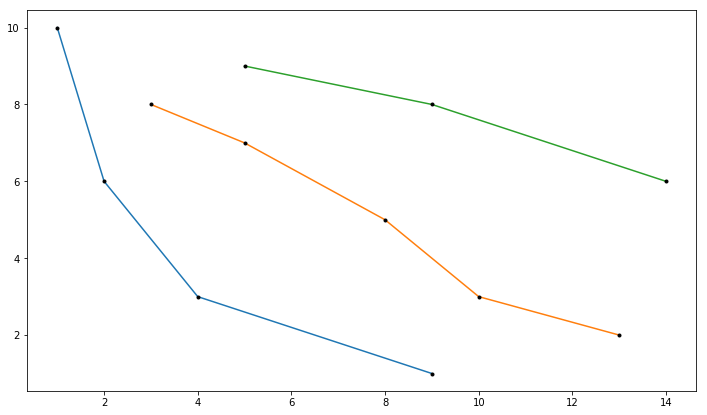

In [12]:
P = np.array([[1,10],[2,6],[3,8],[4,3],[5,7],[5,9],[8,5],[9,1],[10,3],[9,8],[13,2],[14,6]])

PF, F = fastNonDominatedSort(P)
I = crowdingDistanceAssignment(PF[0])

fig, ax = plt.subplots(1, figsize=(12,7))
for i in range(len(PF)):
    ax.plot(PF[i][:,0],PF[i][:,1])
    ax.plot(PF[i][:,0],PF[i][:,1],'k.')

## 1.2 Multiobjective testing of the $\texttt{fastNonDominatedSort}$ and $\texttt{crowdingDistanceAssignment}$ functions

### 1.2.1 Function definition

In [13]:
funNo = 2

def fun(x,y,no):
    """Objective function evaluation 
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the function that wants to be evaluated
    (although not an input, this function should be used with a defined funNo)

    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This will return the 'no' functions evaluated in x and y with the number of times 
    that the function has been called (this will be translated in CFD evaluations). 
    This follows Python notation where the first function is 0, the second is 1,...
    """
    
    #Attribute of the function to know the real number of callings to the function
    fun.counter += x.shape[0]/funNo
    
    # Conditional case for each one of the functions
    if no == 0:
        return 4*x**2+4*y**2
    if no == 1:
        return (x-5)**2+(y-5)**2

### 1.2.2 Domain

In [14]:
x_low = 0
x_high = 5
y_low = 0
y_high = 3

### 1.2.3 Constraints definition

In [15]:
def const(x,y,no):
    """Parameter space constraints for x and y values
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the constraint that wants to be evaluated
    (although not an input, this function should be used with constVal and
    compMode lists that have the constraints values)
    
    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This function evaluates the constraints for the set of values in x and y in the
    desired function no-th. This follows Python notation where the first function is
    0, the second is 1,...
    """
    
    # Conditional for each constraint
    if no == 0:
        return (x-5)**2+y**2
    if no == 1:
        return (x-8)**2+(y+3)**2
    # Conditional for domain
    if no == 2:
        return x
    if no == 3:
        return x
    if no == 4:
        return y
    if no == 5:
        return y
    
constVal = [25, 7.7, x_high, x_low, y_high, y_low]
compMode = ['leq', 'geq', 'leq', 'geq', 'leq', 'geq']

In [16]:
def constrainedPts(points, const, constVal, compMode):
    """Function that will constraint points out of bounds
    
    INPUTS:
    points:     points in the parameter search space as a numpy.ndarray
    const:      function with search space components and constraints number
    constVal:   comparison value for each constraint as list
    compMode:   comparison mode ('leq','geq','less','greater','equal') as list
    
    OUTPUTS:
    booleanMat: boolean matrix with 1 for the non valid points (constrained)
    
    This function will evaluate the constraints for all points in the set returning a 
    boolean masked matrix with the values that are constrained. It will raise an error
    in there is something wrong with the comparison mode. 
    """
    
    #Let's create a function that checks if any of the points is constrained and returns its boolean
    boolMat = np.zeros([len(constVal), points.shape[0]])
    #Let's get the points that are valid under the constraints
    for i in range(len(constVal)):
        if compMode[i] == 'leq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) < constVal[i],
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'less':
            boolMat[i,:] = const(points[:,0], points[:,1], i) < constVal[i]
        elif compMode[i] == 'geq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) > constVal[i], 
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'greater':
            boolMat[i,:] = const(points[:,0], points[:,1], i) > constVal[i]
        elif compMode[i] == 'eq':
            boolMat[i,:] = const(points[:,0], points[:,1], i) == constVal[i]
        else:
            raise RuntimeError('Bad comparison mode matrix')
    #Once all the comparisons are made, the output should be an OR array along the boolMat
    return np.logical_or.reduce(np.logical_not(boolMat))

### 1.2.4 Function testing

In [17]:
#Number of used points
noPoints = 200

#Get a random set of points
x = x_low+np.random.rand(noPoints)*(x_high-x_low)
y = y_low+np.random.rand(noPoints)*(y_high-y_low)

#Make a copy of the points X-Y to extract the valid ones
valid_x = np.copy(x)
valid_y = np.copy(y)

#Let's get the points that are valid under the constraints
for i in range(len(constVal)):
    if compMode[i] == 'leq':
        boolMat = np.logical_or(const(valid_x, valid_y, i) < constVal[i], const(valid_x, valid_y, i) == constVal[i])
    elif compMode[i] == 'less':
        boolMat = const(valid_x, valid_y, i) < constVal[i]
    elif compMode[i] == 'geq':
        boolMat = np.logical_or(const(valid_x, valid_y, i) > constVal[i], const(valid_x, valid_y, i) == constVal[i])
    elif compMode[i] == 'greater':
        boolMat = const(valid_x, valid_y, i) > constVal[i]
    elif compMode[i] == 'eq':
        boolMat = const(valid_x, valid_y, i) == constVal[i]
    else:
        print('Bad comparison mode matrix')
    valid_x = valid_x[boolMat] 
    valid_y = valid_y[boolMat]

#Evaluate the function for all points and for the valid ones
valid_values = np.zeros([len(valid_x), funNo])

#Function attribute counter
fun.counter = 0

for i in range(funNo):
    valid_values[:,i] = fun(valid_x, valid_y, i)

In [18]:
PF, _ = fastNonDominatedSort(valid_values)
I0 = crowdingDistanceAssignment(PF[0])
# I8 = crowdingDistanceAssignment(PF[8])

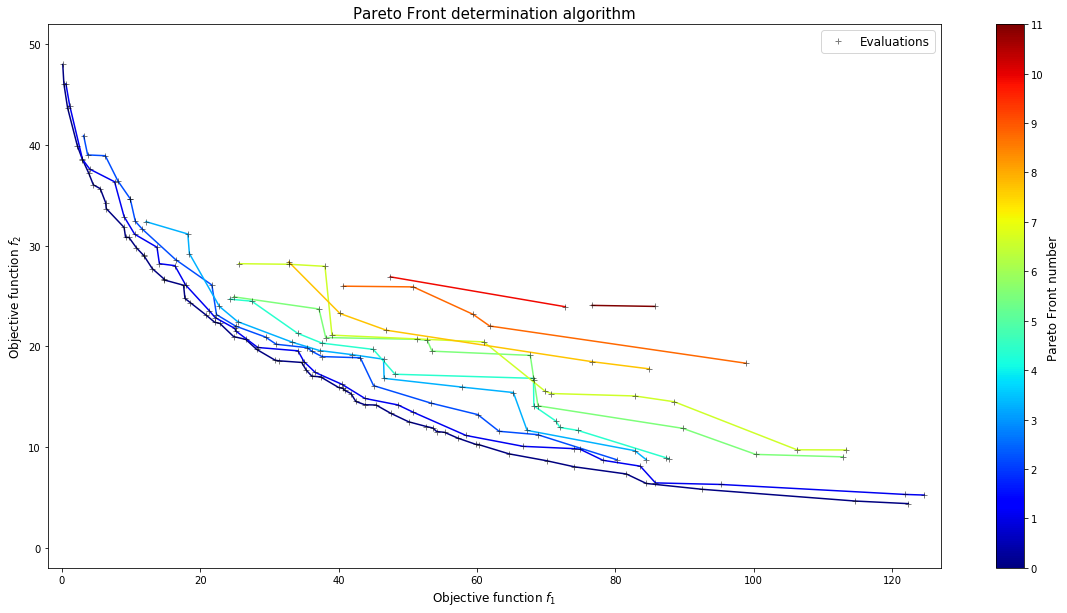

In [19]:
fig, ax0 = plt.subplots(1, figsize=(20,10))
color = cm.jet(np.linspace(0,1,len(PF)))
for i in range(len(PF)):
    ax0.plot(PF[i][np.argsort(PF[i][:,0]),0],PF[i][np.argsort(PF[i][:,0]),1], c = color[i])
ax0.plot(valid_values[:,0],valid_values[:,1],'k+', alpha=0.5, label='Evaluations')
ax0.set_xlabel('Objective function $f_1$', fontsize=12)
ax0.set_ylabel('Objective function $f_2$', fontsize=12)
ax0.set_title('Pareto Front determination algorithm', fontsize=15)
ax0.set_xlim([-2,127])
ax0.set_ylim([-2,52])
ax0.legend(fontsize=12)
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=len(PF)))
# Plot the legend of the colormap
sm._A = []
cbar = plt.colorbar(sm)
cbar.ax.set_yticklabels([np.linspace(0,len(PF),len(PF)+1)])
cbar.set_ticks([np.linspace(0,len(PF),len(PF)+1)])
cbar.set_label('Pareto Front number ', rotation=90, fontsize=12)

Text(0.5,1,'First objective function')

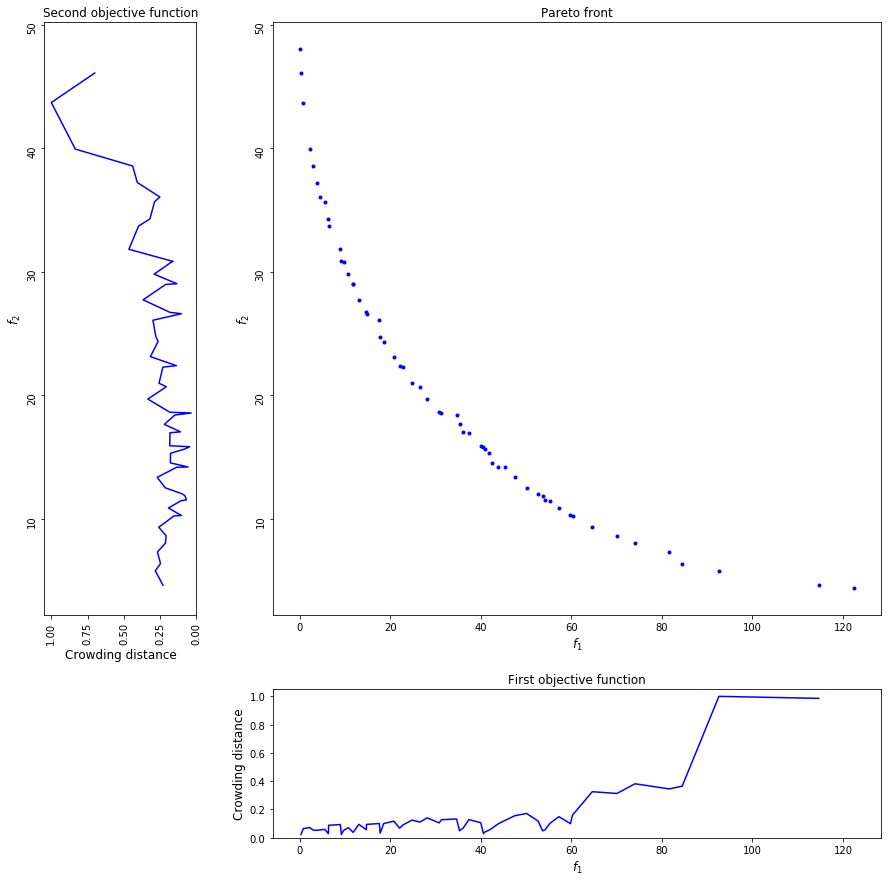

In [20]:
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2, width_ratios=[1, 4], height_ratios=[4, 1])
axUL = fig.add_subplot(grid[0]) #upper left
axLR = fig.add_subplot(grid[3]) #lower right
axUR = fig.add_subplot(grid[1]) #upper right

axUR.plot(PF[0][:,0],PF[0][:,1], 'b.')
axUR.tick_params(axis='y', rotation=90)
axUR.set_xlabel('$f_1$',fontsize=12)
axUR.set_ylabel('$f_2$',fontsize=12)
axUR.set_title('Pareto front')

axUL.plot(I0[np.argsort(PF[0][:,0]),1],PF[0][np.argsort(PF[0][:,0]),1],'b')
axUL.set_xlim((0,None))
axUL.set_xlim(axUL.get_xlim()[::-1])
axUL.set_ylim(axUR.get_ylim())
axUL.tick_params(axis='x', rotation=90)
axUL.tick_params(axis='y', rotation=90)
axUL.set_xlabel('Crowding distance', fontsize=12)
axUL.set_ylabel('$f_2$',fontsize=12)
axUL.set_title('Second objective function')

axLR.plot(PF[0][np.argsort(PF[0][:,0]),0],I0[np.argsort(PF[0][:,0]),0],'b')
axLR.set_xlim(axUR.get_xlim())
axLR.set_ylim((0,None))
axLR.set_xlabel('$f_1$',fontsize=12)
axLR.set_ylabel('Crowding distance',fontsize=12)
axLR.set_title('First objective function')

## 1.3 Preselection test

In [21]:
N = 100

# Initialization of the population
x1 = initialization(N, True, False, False)
x2 = initialization(N, True, False, False)

# Preallocation of space for the temporary function evaluation
fE1 = np.zeros((N,funNo))
fE2 = np.zeros((N,funNo))

# Evaluation of the functions 
for i in range(funNo):
    fE1[:,i] = fun(x1[:,0], x1[:,1], i)
    fE2[:,i] = fun(x2[:,0], x2[:,1], i)

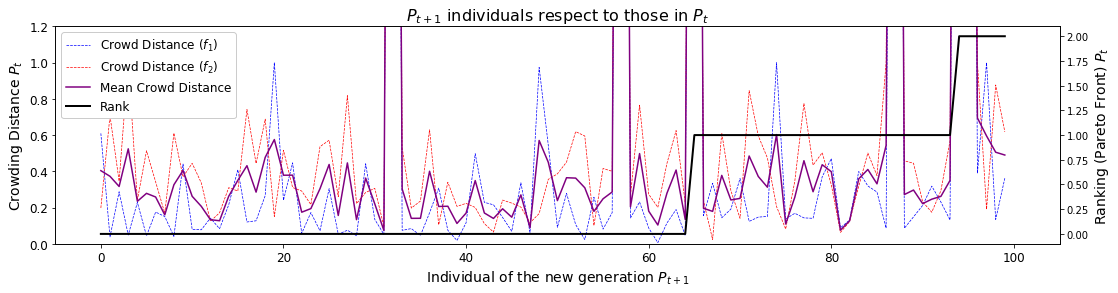

In [23]:
a = preSelection(x1,x2,fE1,fE2)

np.place(a[:,5],a[:,5]==np.float('inf'),9)
np.place(a[:,6],a[:,6]==np.float('inf'),9)

fig, ax1 = plt.subplots(1, figsize=(18,4))
ax1.plot(a[:,5],'b--',linewidth=0.7,label='Crowd Distance ($f_1$)')
ax1.plot(a[:,6],'r--',linewidth=0.7,label='Crowd Distance ($f_2$)')
ax1.plot((a[:,5]+a[:,6])/2,color='purple',linewidth=1.5,label='Mean Crowd Distance')
ax1.plot([2*noPoints,2*noPoints+1],[2*noPoints,2*noPoints+1],'k',linewidth=2,label='Rank')
ax1.set_xlim([-N/20,1.05*N])
ax1.set_ylim([0.,1.2]);
ax2 = ax1.twinx()
ax2.plot(a[:,4],'k',linewidth=2,label='Rank')
ax1.set_xlabel('Individual of the new generation $P_{t+1}$',fontsize=14)
ax1.set_ylabel('Crowding Distance $P_{t}$',fontsize=14)
ax2.set_ylabel('Ranking (Pareto Front) $P_{t}$',fontsize=14)
ax1.set_title('$P_{t+1}$ individuals respect to those in $P_t$',fontsize=16)
ax1.tick_params(axis='both', which='both', labelsize=12)
leg = ax1.legend(loc='upper left', fontsize=12)
leg.get_frame().set_alpha(1)

## 1.4 Binary tournament tests

Text(0.5,1,'Crowding distance & mean crowding distance')

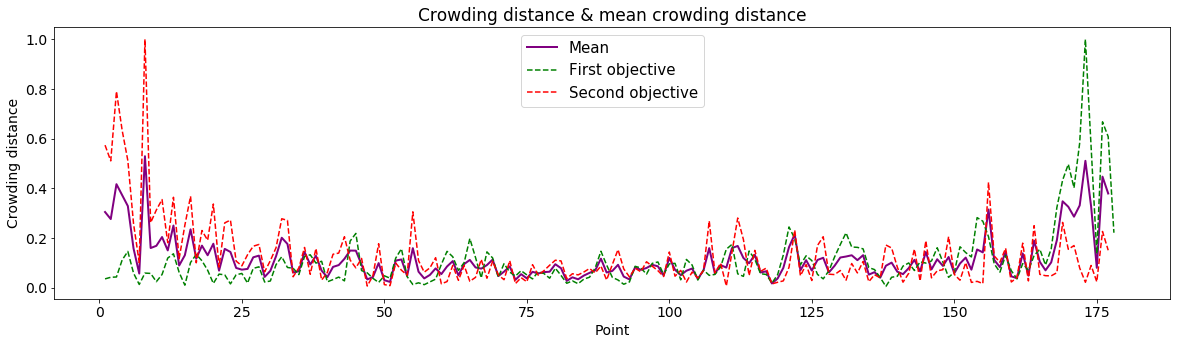

In [24]:
I = crowdingDistanceAssignment(valid_values)

fig, ax = plt.subplots(1, figsize=(20,5))
ax.plot(np.mean(np.array([I[np.argsort(valid_values[:,0]),0],I[np.argsort(valid_values[:,0]),1]]),axis=0),
        color='purple',label='Mean',linewidth=2)
ax.plot(I[np.argsort(valid_values[:,0]),0],'--g',label='First objective')
ax.plot(I[np.argsort(valid_values[:,0]),1],'--r',label='Second objective')
ax.set_xlabel('Point', fontsize = 14)
ax.set_ylabel('Crowding distance', fontsize = 14)
ax.tick_params(labelsize=14)
ax.legend(fontsize=15)
ax.set_title('Crowding distance & mean crowding distance', fontsize=17)

In [25]:
rank = np.array([0,2,0,0,1,0,2,0,3,1,3,2])
crowd = np.array([[0.7,0.3],[0.15,0.4],[np.inf,0.5],[0.1,0.05],[0.4,np.inf],[0.5,0.03],[0.15,0.4],[0.23,0.5],[0.33,0.6],[0.4,0.6],[0.5,0.5],[0.1,0.2]])

table = PrettyTable(['Index', 'Rank', 'CrowdD 1', 'CrowdD 2', 'CrowdD Mean'])
for i in range(len(rank)):
    table.add_row([i, rank[i], crowd[i,0], crowd[i,1], np.round(np.mean((crowd[i,0],crowd[i,1])),3)])
print(table)

+-------+------+----------+----------+-------------+
| Index | Rank | CrowdD 1 | CrowdD 2 | CrowdD Mean |
+-------+------+----------+----------+-------------+
|   0   |  0   |   0.7    |   0.3    |     0.5     |
|   1   |  2   |   0.15   |   0.4    |    0.275    |
|   2   |  0   |   inf    |   0.5    |     inf     |
|   3   |  0   |   0.1    |   0.05   |    0.075    |
|   4   |  1   |   0.4    |   inf    |     inf     |
|   5   |  0   |   0.5    |   0.03   |    0.265    |
|   6   |  2   |   0.15   |   0.4    |    0.275    |
|   7   |  0   |   0.23   |   0.5    |    0.365    |
|   8   |  3   |   0.33   |   0.6    |    0.465    |
|   9   |  1   |   0.4    |   0.6    |     0.5     |
|   10  |  3   |   0.5    |   0.5    |     0.5     |
|   11  |  2   |   0.1    |   0.2    |     0.15    |
+-------+------+----------+----------+-------------+


In [26]:
table = PrettyTable(['Index', 'Rank', 'CrowdD Mean'])
for i in prec_n_operator(rank,crowd):
    table.add_row([i, rank[i], np.round(np.mean((crowd[i,0],crowd[i,1])),3)])
print(table)

+-------+------+-------------+
| Index | Rank | CrowdD Mean |
+-------+------+-------------+
|   2   |  0   |     inf     |
|   0   |  0   |     0.5     |
|   7   |  0   |    0.365    |
|   5   |  0   |    0.265    |
|   3   |  0   |    0.075    |
|   4   |  1   |     inf     |
|   9   |  1   |     0.5     |
|   6   |  2   |    0.275    |
|   1   |  2   |    0.275    |
|   11  |  2   |     0.15    |
|   10  |  3   |     0.5     |
|   8   |  3   |    0.465    |
+-------+------+-------------+


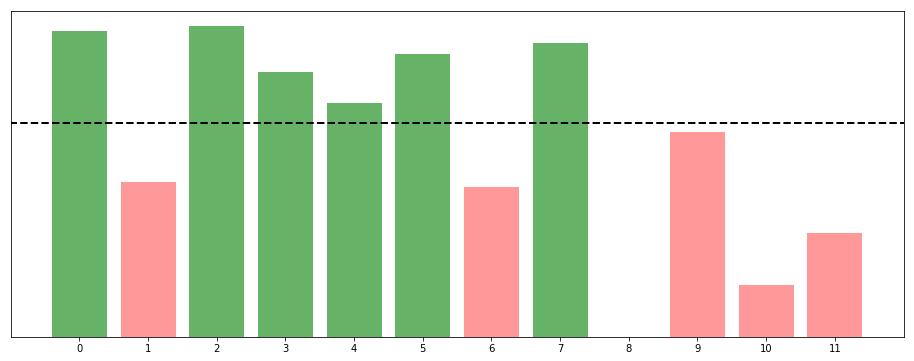

In [27]:
binT = -1*np.ones((1000,int(len(rank)/2)))

for i in range(binT.shape[0]):
    for j in range(binT.shape[1]):
        newElement = binaryTournament(rank, crowd)
        while newElement in binT[i,:]:
            newElement = binaryTournament(rank, crowd)
        binT[i,j] = newElement

unique, counts = np.unique(binT, return_counts=True)

fig, ax = plt.subplots(1, figsize=(16,6))
ax.bar(unique[counts > np.mean(counts)],counts[counts > np.mean(counts)],color='g',alpha=0.6);
ax.bar(unique[counts < np.mean(counts)],counts[counts < np.mean(counts)],color='r',alpha=0.4);
ax.plot([-10,100],[np.mean(counts),np.mean(counts)],'k--',linewidth=2)
ax.set_yticks([])
ax.set_xticks(np.linspace(0,len(rank)-1,len(rank)))
ax.set_xlim([-1,len(rank)]);

With a number high enough of populations, it can be seen that the best individuals are chosen. This doesn't mean that when running a random population other individuals below the mean may appear (except from the individual with highest rank and lowest crowding distance)

In [28]:
npopulation = []
for i in range(int(len(rank)/2)):
    chosenInd = binaryTournament(rank, crowd)
    if i == 0:
        npopulation.append(chosenInd)
    else:
        while int(chosenInd) in npopulation:
            chosenInd = binaryTournament(rank, crowd)
        npopulation.append(chosenInd)
        
print(np.sort(npopulation))

[2 3 4 5 7 9]


## 1.5 Crossover testing

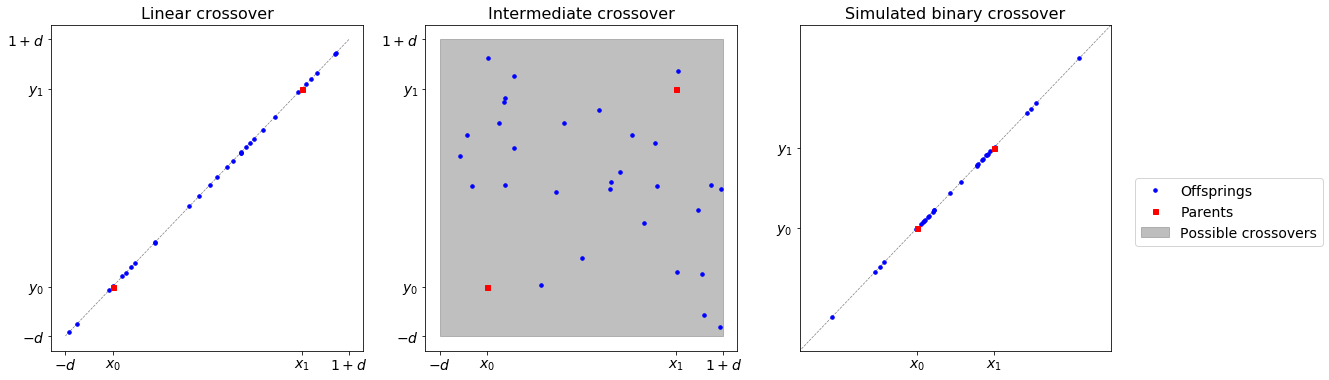

In [29]:
pt1 = np.array([1.,1.])
pt2 = np.array([0.,0.])
d = 0.25

linearC = np.zeros((30,2))
intermC = np.zeros_like(linearC)
sbxC = np.zeros_like(linearC)

for i in range(len(linearC)):
    linearC[i,:] = crossover(pt1, pt2, d, np.nan, True, False)
    intermC[i,:] = crossover(pt1, pt2, d, np.nan, False, False)

for i in range(int(len(linearC)/2)):
    sbxC[i,:], sbxC[i+int(len(linearC)/2),:] = crossover(pt1, pt2, np.nan, 2, False, True)
    
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(19,6))
########## PLOT 1
ax1.plot([(1+d)*np.abs(pt1[0]-pt2[0]),(-d)*np.abs(pt1[0]-pt2[0])], [(1+d)*np.abs(pt1[1]-pt2[1]),(-d)*np.abs(pt1[1]-pt2[1])] ,'--k', linewidth=0.7,alpha=0.5)
ax1.plot(linearC[:,0], linearC[:,1], '.b', markersize=7)
ax1.plot([pt1[0],pt2[0]], [pt1[1],pt2[1]], 'sr', markersize = 5, label ='Parents')
ax1.set_title('Linear crossover', fontsize=16)

ax1.set_xticks([(-d)*np.abs(pt1[0]-pt2[0]),pt2[0],pt1[0],(1+d)*np.abs(pt1[0]-pt2[0])])
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$x_0$'
labels[2] = r'$x_1$'
labels[3] = r'$1+d$'
ax1.set_xticklabels(labels, fontsize=14)

ax1.set_yticks([(-d)*np.abs(pt1[1]-pt2[1]),pt2[1],pt1[1],(1+d)*np.abs(pt1[1]-pt2[1])])
labels = [item.get_text() for item in ax1.get_yticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$y_0$'
labels[2] = r'$y_1$'
labels[3] = r'$1+d$'
ax1.set_yticklabels(labels, fontsize=14)

########## PLOT 2
ax2.fill_between([-d,1+d],[1+d,1+d],[-d,-d],color='grey',alpha=0.5, label='Possible crossovers')
ax2.plot(intermC[:,0], intermC[:,1], '.b', markersize=7, label='Offsprings')
ax2.plot([pt1[0],pt2[0]], [pt1[1],pt2[1]], 'sr', markersize = 5, label ='Parents')
ax2.set_title('Intermediate crossover', fontsize=16)

ax2.set_xticks([(-d)*np.abs(pt1[0]-pt2[0]),pt2[0],pt1[0],(1+d)*np.abs(pt1[0]-pt2[0])])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$x_0$'
labels[2] = r'$x_1$'
labels[3] = r'$1+d$'
ax2.set_xticklabels(labels, fontsize=14)

ax2.set_yticks([(-d)*np.abs(pt1[1]-pt2[1]),pt2[1],pt1[1],(1+d)*np.abs(pt1[1]-pt2[1])])
labels = [item.get_text() for item in ax2.get_yticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$y_0$'
labels[2] = r'$y_1$'
labels[3] = r'$1+d$'
ax2.set_yticklabels(labels, fontsize=14)

########## PLOT 3
ax3.plot([-10, 10], [-10,10] ,'--k', linewidth=0.7, alpha=0.5)
ax3.plot(sbxC[:,0], sbxC[:,1], '.b', markersize=7)
ax3.plot([pt1[0],pt2[0]], [pt1[1],pt2[1]], 'sr', markersize = 5, label ='Parents')
ax3.set_title('Simulated binary crossover', fontsize=16)

ax3.set_xticks([pt2[0],pt1[0]])
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels[0] = r'$x_0$'
labels[1] = r'$x_1$'
ax3.set_xticklabels(labels, fontsize=14)

ax3.set_yticks([pt2[1],pt1[1]])
labels = [item.get_text() for item in ax3.get_yticklabels()]
labels[0] = r'$y_0$'
labels[1] = r'$y_1$'
ax3.set_yticklabels(labels, fontsize=14)

ax3.set_xlim([pt1[0]-1.2*np.max(np.abs(sbxC[:,0])),1.2*np.max(np.abs(sbxC[:,0]))])
ax3.set_ylim([pt1[1]-1.2*np.max(np.abs(sbxC[:,1])),1.2*np.max(np.abs(sbxC[:,1]))])

# Legend
ax2.legend(bbox_to_anchor=(2.9,0.55),fontsize=14)

## 1.6 Mutation testing and parameter sweep

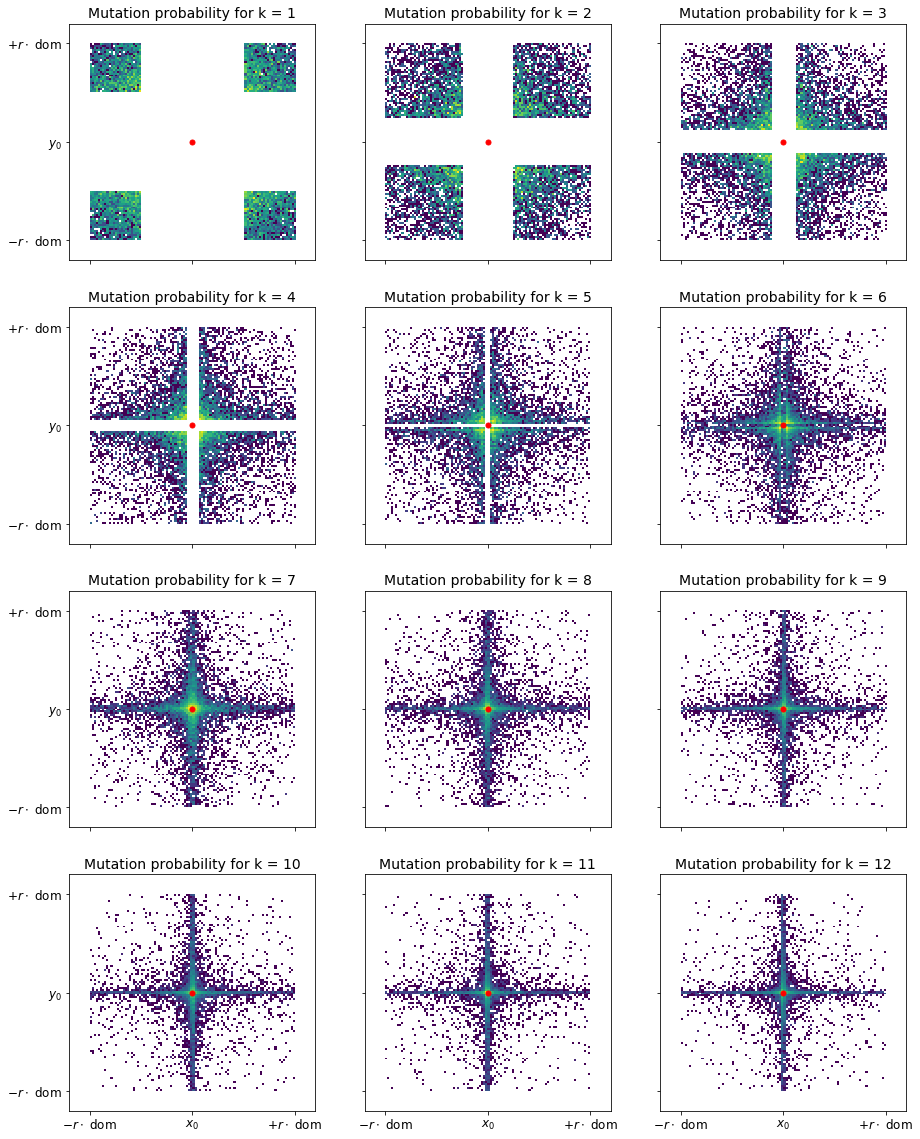

In [51]:
kPS = np.zeros((10000,2))

K = [1,2,3,4,5,6,7,8,9,10,11,12]
kVal = 0
    
fig, ax = plt.subplots(4, 3, figsize=(15,20), sharex='col', sharey='row')
for i in range(4):
    for j in range(3):
        for k in range(len(kPS)):
            kPS[k,:] = mutation(np.array([0.,0.]), 0.1, np.array([-0.5,0.5,-0.5,0.5]), K[kVal], np.nan, False, False)
        ax[i][j].hist2d(kPS[:,0], kPS[:,1], bins=100, norm=LogNorm())
        ax[i][j].plot([0.], [0.], 'or', markersize = 5)
        ax[i][j].set_xlim([-0.12,0.12])
        ax[i][j].set_ylim([-0.12,0.12])
        ax[i][j].set_title('Mutation probability for k = %i' %K[kVal], fontsize=14)
        
        ax[i][j].set_xticks([-0.1,0,0.1])
        if i == 3:
            labels = [item.get_text() for item in ax[i][j].get_xticklabels()]
            labels[0] = r'$-r\cdot$ dom'
            labels[1] = r'$x_0$'
            labels[2] = r'$+r\cdot$ dom'
            ax[i][j].set_xticklabels(labels, fontsize=12)

        ax[i][j].set_yticks([-0.1,0,0.1])
        if j == 0:
            labels = [item.get_text() for item in ax[i][j].get_yticklabels()]
            labels[0] = r'$-r\cdot$ dom'
            labels[1] = r'$y_0$'
            labels[2] = r'$+r\cdot$ dom'
            ax[i][j].set_yticklabels(labels, fontsize=12)
        
        kVal += 1

[Text(0,0,'$-y_{lim}$'), Text(0,0,'$y_0$'), Text(0,0,'$y_{lim}$')]

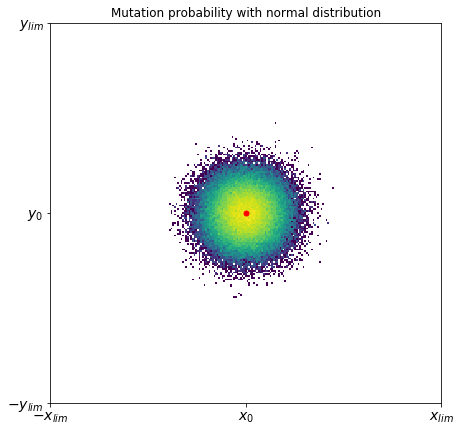

In [52]:
norm = np.zeros((100000,2))

for k in range(len(norm)):
    norm[k,:] = mutation(np.array([0.,0.]), 0.2, np.array([-0.5,0.5,-0.5,0.5]), np.nan, np.nan, True, False)

fig, ax = plt.subplots(1, figsize=(7,7))
ax.hist2d(norm[:,0], norm[:,1], bins=100, norm=LogNorm())
ax.plot([0.], [0.], 'or', markersize = 5)
ax.set_title('Mutation probability with normal distribution')

ax.set_xticks([-0.5,0,0.5])
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = r'$-x_{lim}$'
labels[1] = r'$x_0$'
labels[2] = r'$x_{lim}$'
ax.set_xticklabels(labels, fontsize=14)

ax.set_yticks([-0.5,0,0.5])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = r'$-y_{lim}$'
labels[1] = r'$y_0$'
labels[2] = r'$y_{lim}$'
ax.set_yticklabels(labels, fontsize=14)

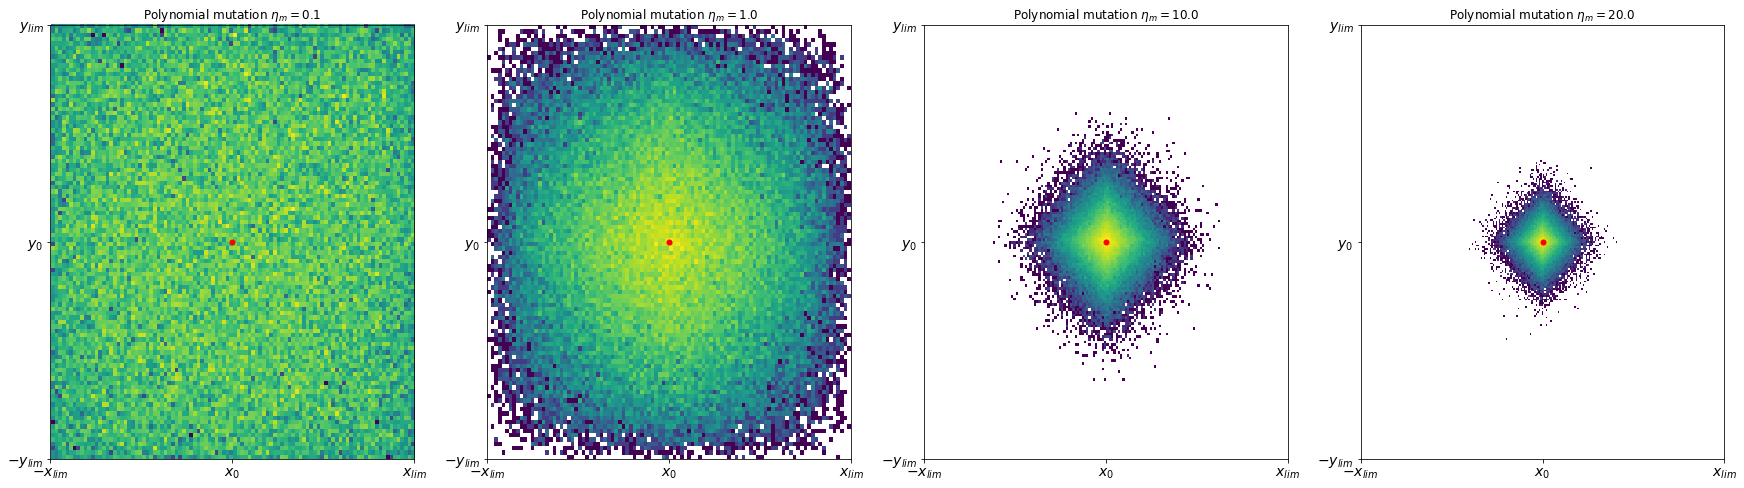

In [53]:
n_m = [0.1,1,10,20]
    
fig, ax = plt.subplots(1, 4, figsize=(30,8))
for i in range(4):

    poly = np.zeros((100000,2))

    for k in range(len(poly)):
        poly[k,:] = mutation(np.array([0.,0.]), np.nan, np.array([-0.5,0.5,-0.5,0.5]), np.nan, n_m[i], False, True)

    ax[i].hist2d(poly[:,0], poly[:,1], bins=100, norm=LogNorm())
    ax[i].plot([0.], [0.], 'or', markersize = 5)
    ax[i].set_title('Polynomial mutation $\eta_m=%.1f$' %n_m[i])

    ax[i].set_xticks([-0.5,0,0.5])
    labels = [item.get_text() for item in ax[i].get_xticklabels()]
    labels[0] = r'$-x_{lim}$'
    labels[1] = r'$x_0$'
    labels[2] = r'$x_{lim}$'
    ax[i].set_xticklabels(labels, fontsize=14)

    ax[i].set_yticks([-0.5,0,0.5])
    labels = [item.get_text() for item in ax[i].get_yticklabels()]
    labels[0] = r'$-y_{lim}$'
    labels[1] = r'$y_0$'
    labels[2] = r'$y_{lim}$'
    ax[i].set_yticklabels(labels, fontsize=14)

## 1.7 Types of initializations

(0, 3)

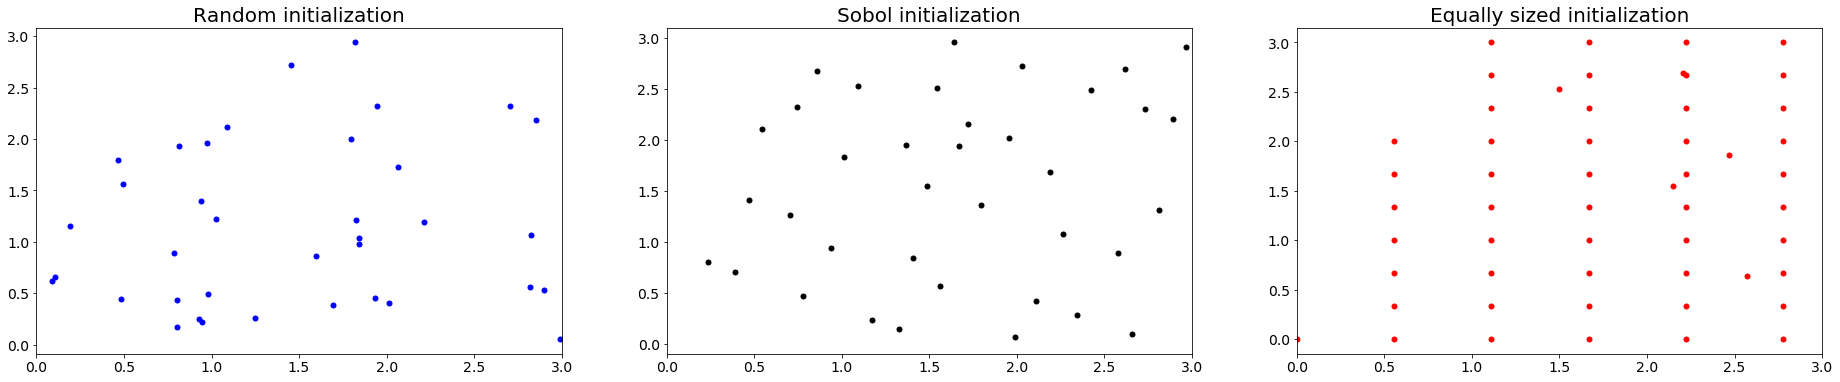

In [30]:
# Number of individuals
N = 64

random = initialization(N, True, False, False)
sobol = initialization(N, False, True, False)
equal = initialization(N, False, False, True)
        
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(32,6))
ax1.plot(random[:,0],random[:,1],'b.', markersize=10)
ax1.tick_params(axis = 'both', labelsize = 14)
ax1.set_title(r'Random initialization', fontsize=20)
ax1.set_xlim([x_low,x_high])
ax1.set_xlim([y_low,y_high])
ax2.plot(sobol[:,0],sobol[:,1],'k.', markersize=10)
ax2.tick_params(axis = 'both', labelsize = 14)
ax2.set_title(r'Sobol initialization', fontsize=20)
ax2.set_xlim([x_low,x_high])
ax2.set_xlim([y_low,y_high])
ax3.plot(equal[:,0],equal[:,1],'r.', markersize=10)
ax3.tick_params(axis = 'both', labelsize = 14)
ax3.set_title(r'Equally sized initialization', fontsize=20)
ax3.set_xlim([x_low,x_high])
ax3.set_xlim([y_low,y_high])


# 2. General multi-objective optimization genetic algorithm

## 2.1 Input parameters

In [31]:
# Function attribute to count callings (future CFD simulations)
fun.counter = 0

# Number of individuals per generation (even number if SBX is True)
N = 100

# Generation list (new generations will be appended at the end)
P = []

# Function evaluation (new evaluations will be appended at the end)
funEval = []

# Current generation
p = 0

# Limit of generations 
pLim = 10

## 2.2 Initial population ($p = 0$)

In [32]:
# Initialization of the population
P.append(initialization(N, False, True, False))

# Preallocation of space for the temporary function evaluation
fE = np.zeros((N,funNo))

# Evaluation of the functions 
for i in range(funNo):
    fE[:,i] = fun(P[p][:,0], P[p][:,1], i)

# Append the temporary function evaluation to the list
funEval.append(fE)

## 2.3 Further populations ($p < p_{Lim}$)

In [33]:
# Generation loop
while p < pLim:
    # Fitness evaluation of the population according to Pareto front rules
    _, F = fastNonDominatedSort(funEval[p])

    # Fitness evaluation of the population according to crowding distance
    I = crowdingDistanceAssignment(P[p])

    # Get the Pareto front number in which all points are located
    PFnumber = np.zeros(len(P[p])) 
    count = 0
    for pfn in range(len(F)):
        for pfe in range(len(F[pfn])):
            PFnumber[F[pfn][pfe].astype(int)] = pfn
            count += 1
    
    # Preallocation of space for the points of the new generation
    newGenPts = np.zeros([N,2])

    # The first generation of the algorithm doesn't go under the preselection process
    for i in range(N):
        # First generation will go straight to binary tournament 
        pt1 = P[p][binaryTournament(PFnumber, I),:]
        pt2 = P[p][binaryTournament(PFnumber, I),:]

        # Let's prevent self point crossover
        while all(pt1 == pt2):
            pt1 = P[p][binaryTournament(PFnumber, I),:]
            pt2 = P[p][binaryTournament(PFnumber, I),:]

        # Recombination will be
        newGenPts[i,:] = crossover(pt1, pt2, 0.25, np.nan, False, False)
        # Also in this first case mutation will be normal  TODO
        newGenPts[i,:] = mutation(newGenPts[i,:], 0.2, 
                                  np.array([x_low, x_high, y_low, y_high]), 0.1, np.nan, True, False)

    # Constrained values will be replaced, given new random numbers in its places
    while sum(constrainedPts(newGenPts, const, constVal, compMode)) != 0:
        # The points where the constraints are not fulfilled ...
        boolMat = constrainedPts(newGenPts, const, constVal, compMode)
        # ... are replaced with random numbers
        for i in np.argwhere(boolMat == True):
            newGenPts[i,:] = np.array([x_low+np.random.rand(1)*(x_high-x_low),y_low+np.random.rand(1)*(y_high-y_low)]).T

    # Advance one generation
    p += 1

    # Save results for this new generation
    P.append(newGenPts)

    # Preallocation of space for the temporary function evaluation
    fE = np.zeros((N,funNo))

    # Evaluation of the functions 
    for i in range(funNo):
        fE[:,i] = fun(P[p][:,0], P[p][:,1], i)
        
    # Append the temporary function evaluation to the list
    funEval.append(fE)

1100.0


Text(0,0.5,'f_2')

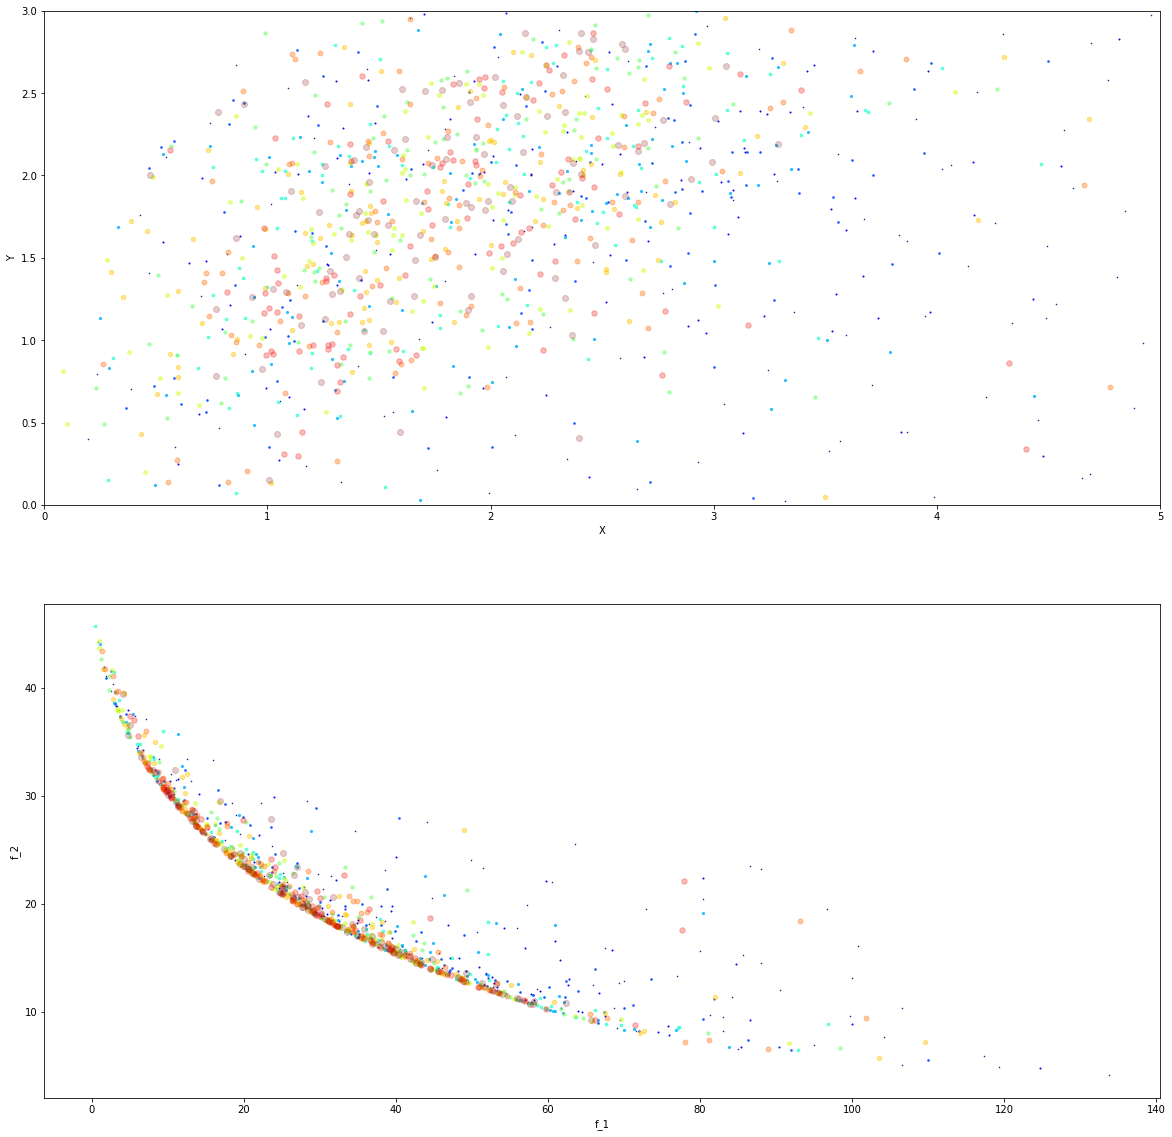

In [34]:
print(fun.counter)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,20))
ms = np.linspace(1,len(P)+1,len(P))
al = np.linspace(1,0.2,len(P))
color = cm.jet(np.linspace(0,1,len(P)))
for i in range(len(P)):
    ax1.plot(P[i][:,0],P[i][:,1],'.',c = color[i], alpha = al[i], markersize = ms[i])
    ax2.plot(funEval[i][:,0],funEval[i][:,1],'.',c = color[i], alpha = al[i], markersize = ms[i])
ax1.set_ylim([0,3])
ax1.set_xlim([0,5])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax2.set_xlabel('f_1')
ax2.set_ylabel('f_2')
# plt.savefig('case.png', bbox_inches = 'tight')

1100.0


(0, 52)

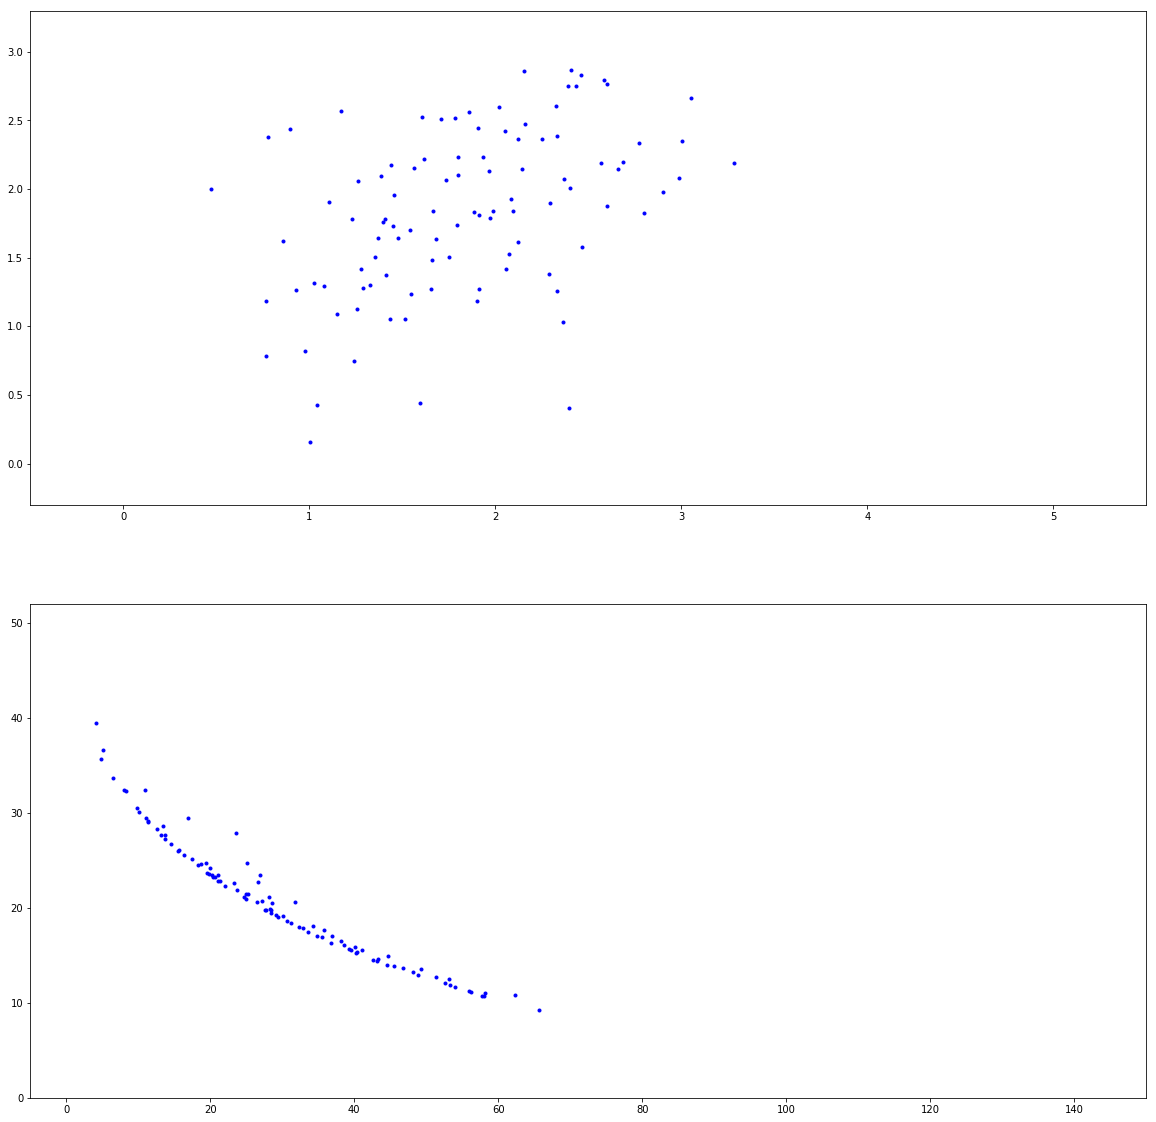

In [35]:
print(fun.counter)
alp = np.linspace(0,1,len(P))
color = cm.jet(np.linspace(0,1,len(P)))
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,20))
i = -1
ax1.plot(P[i][:,0],P[i][:,1],'b.')
ax1.set_xlim([-0.5,5.5])
ax1.set_ylim([-0.3,3.3])
ax2.plot(funEval[i][:,0],funEval[i][:,1],'b.')
ax2.set_xlim([-5,150])
ax2.set_ylim([0,52])
#     plt.savefig('%i.png' %i)

# 3. NSGA-II LOOP

## 3.1 Input parameters

In [36]:
# Function attribute to count callings (future CFD simulations)
fun.counter = 0

# Number of individuals per generation (even number if SBX is True)
N = 100

# Generation list (new generations will be appended at the end)
P = []

# Function evaluation (new evaluations will be appended at the end)
funEval = []

# Current generation
p = 0

# Limit of generations 
pLim = 10

# Crossover probability
crossProb = 0.9

## 3.2 Initial population ($p = 0$)

In [37]:
# Initialization of the population
P.append(initialization(2*N, False, True, False))

# Preallocation of space for the temporary function evaluation
fE = np.zeros((2*N,funNo))

# Evaluation of the functions 
for i in range(funNo):
    fE[:,i] = fun(P[p][:,0], P[p][:,1], i)

# Append the temporary function evaluation to the list
funEval.append(fE)

# Selection of the parents for the first generation
parents = preSelection(P[p][0:N],P[p][N:2*N],funEval[p][0:N],funEval[p][N:2*N])

## 3.3 Further populations ($p < p_{Lim}$)

In [38]:
# Generation loop
while p < pLim - 1:
    # Get the size of the mating pool
    poolSize = round(N/2)
    
    # Create a list to store the index of the better individuals
    pool = [] 
    
    # Filling the mating pool with binary tournament 
    for i in range(poolSize):
        
        # Binary tournament based on the preselected individuals 
        # and its values of Pareto Front rank and its crowding distance
        chosenInd = binaryTournament(parents[:,4], parents[:,5:7])
        
        # The first element will never be on the list
        if i == 0:
            pool.append(chosenInd)
        # For the following individuals
        else:
            # Test if the individual is on the pool
            while int(chosenInd) in pool:
                # And make a binary tournament again if it already is
                chosenInd = binaryTournament(parents[:,4], parents[:,5:7])
            # Appending once the chosen individual is not in the pool
            pool.append(chosenInd)

    # Preallocation of space for the children
    children = np.zeros([N,2])

    # Looping over the whole length of the generation
    for i in range(N):
        # If the random chosen value is below the crossover probability
        if np.random.rand(1) < crossProb:
            
            # Selection of two points with the binary tournament
            pt1 = parents[np.random.choice(pool),0:2]
            pt2 = parents[np.random.choice(pool),0:2]
            
            # Let's prevent self point crossover
            while all(pt1 == pt2):
                pt1 = parents[np.random.choice(pool),0:2]
                pt2 = parents[np.random.choice(pool),0:2]

            # Using simulated binary crossover with n_c = 20
            children[i,:] = crossover(pt1, pt2, 0.0, 20, False, True)[0]
            
            # Applying a smaller mutation to the latest created individual
            children[i,:] = mutation(pt1, 0.2, 
                                      np.array([x_low, x_high, y_low, y_high]), 
                                     6, 50, False, True)

        # If it is not crossover, then it must be mutation 
        else:
            
            # Selection of one point with the binary tournament
            pt1 = parents[np.random.choice(pool),0:2]
            
            # Using polynomial mutation with n_m = 20
            children[i,:] = mutation(pt1, 0.2, 
                                      np.array([x_low, x_high, y_low, y_high]), 
                                     6, 20, False, True)

        # Constrained values will be replaced, given new random numbers in its places
        while sum(constrainedPts(children, const, constVal, compMode)) != 0:
            # The points where the constraints are not fulfilled ...
            boolMat = constrainedPts(children, const, constVal, compMode)
            # ... are replaced with random numbers
            for i in np.argwhere(boolMat == True):
                children[i,:] = np.array([x_low+np.random.rand(1)*(x_high-x_low),
                                          y_low+np.random.rand(1)*(y_high-y_low)]).T

    # Children matrix will be appended to the population
    P.append(children[:,0:2])
                
    # Preallocation of space for the function evaluation
    fEc = np.zeros((N,funNo))

    # Evaluation of the functions 
    for i in range(funNo):
        fEc[:,i] = fun(children[:,0], children[:,1], i)

    # Append the value of the function 
    funEval.append(fEc)
        
    # Choose the better between the parents and the children mixed set
    parents = preSelection(parents[:,0:2],children,parents[:,2:4],fEc)
    
    # Advance current generation counter
    p += 1

1100.0


Text(0,0.5,'f_2')

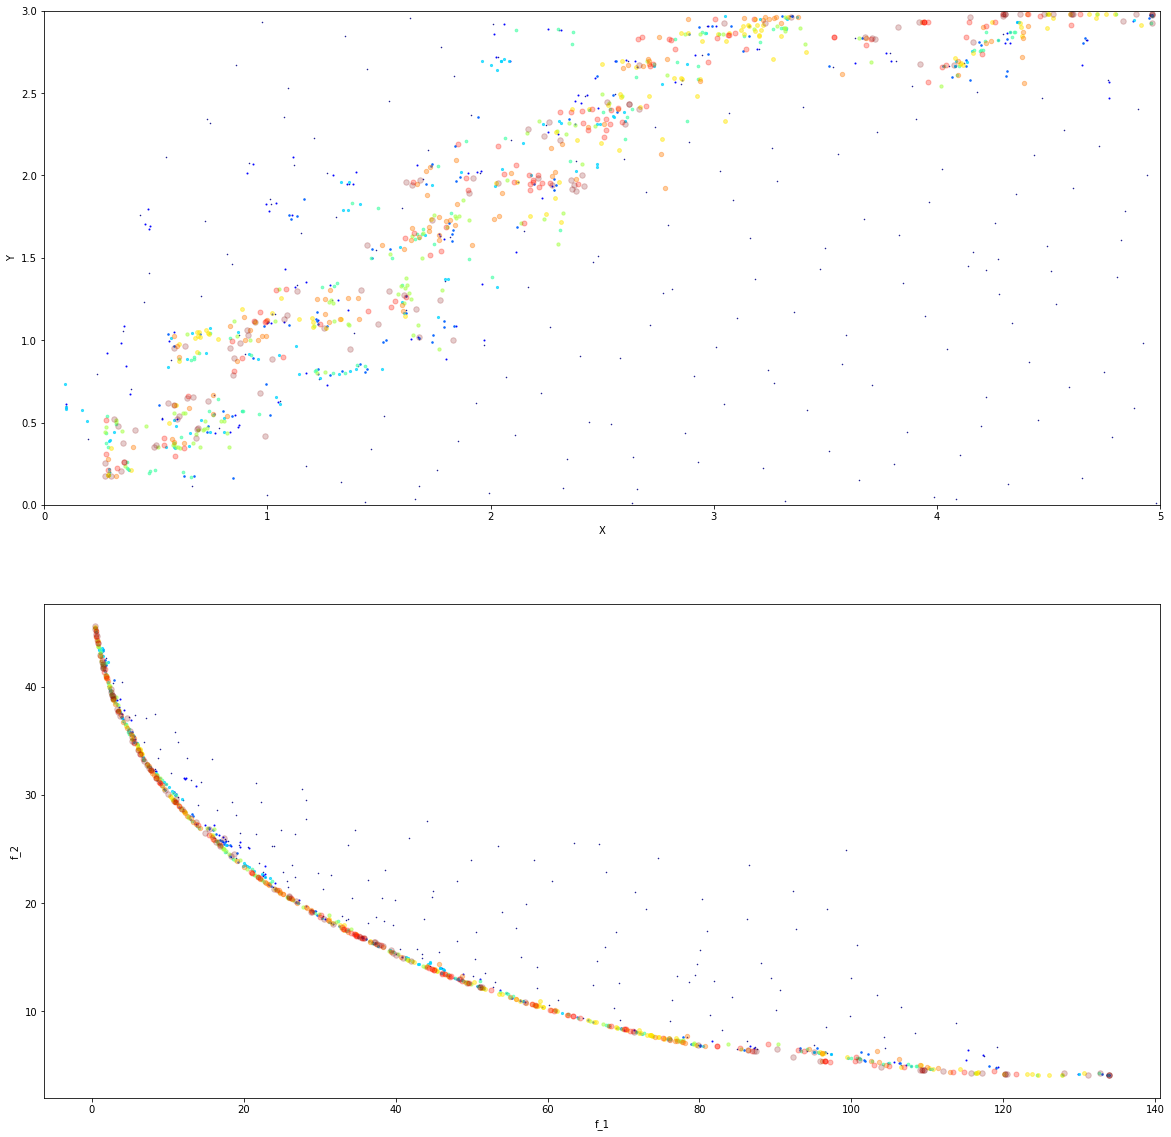

In [39]:
print(fun.counter)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,20))
ms = np.linspace(1,len(P)+1,len(P))
al = np.linspace(1,0.2,len(P))
color = cm.jet(np.linspace(0,1,len(P)))
for i in range(len(P)):
    ax1.plot(P[i][:,0],P[i][:,1],'.',c = color[i], alpha = al[i], markersize = ms[i])
    ax2.plot(funEval[i][:,0],funEval[i][:,1],'.',c = color[i], alpha = al[i], markersize = ms[i])
ax1.set_ylim([0,3])
ax1.set_xlim([0,5])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax2.set_xlabel('f_1')
ax2.set_ylabel('f_2')
# plt.savefig('case.png', bbox_inches = 'tight')

1100.0


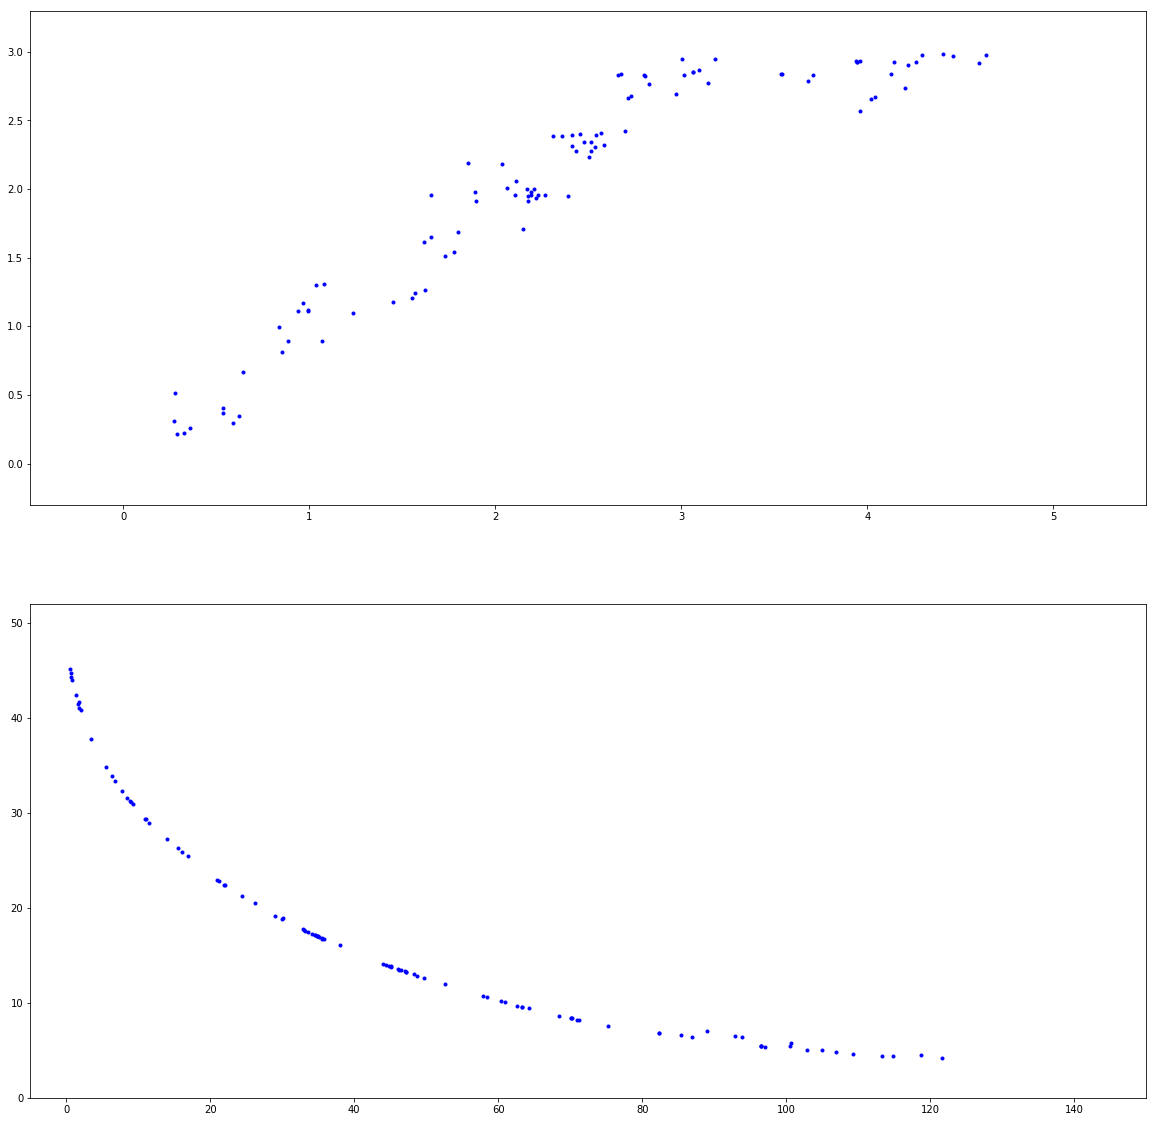

In [42]:
print(fun.counter)
alp = np.linspace(0,1,len(P))
color = cm.jet(np.linspace(0,1,len(P)))
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,20))
i = -2
ax1.plot(P[i][:,0],P[i][:,1],'b.')
ax1.set_xlim([-0.5,5.5])
ax1.set_ylim([-0.3,3.3])
ax2.plot(funEval[i][:,0],funEval[i][:,1],'b.')
ax2.set_xlim([-5,150])
ax2.set_ylim([0,52])
# plt.savefig('NSGAII.png', bbox_inches='tight')